<a href="https://colab.research.google.com/github/brepowell/ML-Contest-Series/blob/main/MLSeriesSupervisedLearningTemplate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Breanna Powell

CSS 539

# To run:
Use an IDE that will allow you to open a Jupyter Notebook.

For example, use Anaconda Navigator to open Visual Studio Code.

You may need to select a kernel to run the program.

I used base(Python 3.10.9)

# DATA GATHERING

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 


## Data Information

From:
https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households

More Info:
https://innovation.ukpowernetworks.co.uk/projects/low-carbon-london

"Created 9 years ago, updated 2 years ago
Energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014.

Readings were taken at half hourly intervals. The customers in the trial were recruited as a balanced sample representative of the Greater London population.

The dataset contains energy consumption, in kWh (per half hour), unique household identifier, date and time. The CSV file is around 10GB when unzipped and contains around 167million rows.

Within the data set are two groups of customers. The first is a sub-group, of approximately 1100 customers, who were subjected to Dynamic Time of Use (dToU) energy prices throughout the 2013 calendar year period. The tariff prices were given a day ahead via the Smart Meter IHD (In Home Display) or text message to mobile phone. Customers were issued High (67.20p/kWh), Low (3.99p/kWh) or normal (11.76p/kWh) price signals and the times of day these applied. The dates/times and the price signal schedule is availaible as part of this dataset. All non-Time of Use customers were on a flat rate tariff of 14.228pence/kWh.

The signals given were designed to be representative of the types of signal that may be used in the future to manage both high renewable generation (supply following) operation and also test the potential to use high price signals to reduce stress on local distribution grids during periods of stress.

The remaining sample of approximately 4500 customers energy consumption readings were not subject to the dToU tariff."


## Load Data -- Daily

In [2]:
# Use Pandas to load the data into a dataframe
path = "data/archive/"
startYear = 2011   # 2011-11-23	is the earliest day I can find in the dataset
endYear = 2014     # 2014-02-28 is the last day I can find in the dataset

londonData = pd.read_csv(path + 'daily_dataset.csv')
londonData.shape


(3510433, 9)

## Load Data -- Half Hourly

In [3]:
# tstp = Time Series Time Period (day)
# This shows readings every half hour (LCLid + tstp + energy(kWh/hh) = 3 columns)
path = "data/archive/halfhourly_dataset/halfhourly_dataset/"
block1 = pd.read_csv(path + 'block_0.csv')
block1.shape


(1222670, 3)

## Load Data -- Half Hourly 2nd set

In [4]:
# This shows readings every half hour (LCLid + day + 48 half hour columns = 50 columns) per day, per ID
# It is the same data as the halfhourly_dataset, except formatted differently and with more precision.
path = "data/archive/hhblock_dataset/hhblock_dataset/"
halfblock0 = pd.read_csv(path + 'block_0.csv')
halfblock0.shape

(25286, 50)

## Drop Null From Daily Data

In [5]:
# Drop any row that has null values
# The last day of data collection was showing lots of null values

#londonData.dropna(inplace=True)

In [6]:
# Lost 11,331 rows of data from (3510433, 9)
londonData.shape

(3510433, 9)

# FEATURE EXPLORATION

## Check the Min/Max/Avg -- Daily

In [7]:
londonData.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


In [8]:
londonData.tail() 

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
3510428,MAC004977,2014-02-24,0.0950,0.118458,0.580,48,0.093814,5.686,0.052
3510429,MAC004977,2014-02-25,0.0675,0.084208,0.176,48,0.037107,4.042,0.046
3510430,MAC004977,2014-02-26,0.1080,0.120500,0.282,48,0.069332,5.784,0.046
3510431,MAC004977,2014-02-27,0.0720,0.114062,0.431,48,0.094482,5.475,0.047
3510432,MAC004977,2014-02-28,0.0970,0.097000,0.097,1,NaN,0.097,0.097


In [9]:
londonData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   LCLid          object 
 1   day            object 
 2   energy_median  float64
 3   energy_mean    float64
 4   energy_max     float64
 5   energy_count   int64  
 6   energy_std     float64
 7   energy_sum     float64
 8   energy_min     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 241.0+ MB


In [10]:
# Zero is the minimum for all except energy_count
londonData.describe()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
count,3.510403e+06,3.510403e+06,3.510403e+06,3.510433e+06,3.499102e+06,3.510403e+06,3.510403e+06
mean,1.587395e-01,2.117305e-01,8.345210e-01,4.780364e+01,1.726673e-01,1.012414e+01,5.962578e-02
std,1.701865e-01,1.908460e-01,6.683156e-01,2.810982e+00,1.531208e-01,9.128793e+00,8.701312e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.700000e-02,9.808333e-02,3.460000e-01,4.800000e+01,6.911626e-02,4.682000e+00,2.000000e-02
50%,1.145000e-01,1.632917e-01,6.880000e-01,4.800000e+01,1.327910e-01,7.815000e+00,3.900000e-02
75%,1.910000e-01,2.624583e-01,1.128000e+00,4.800000e+01,2.293124e-01,1.256900e+01,7.100000e-02
max,6.970500e+00,6.928250e+00,1.076100e+01,4.800000e+01,4.024569e+00,3.325560e+02,6.524000e+00


In [11]:
# There are 5566 distinct LCLids (customers) originally - became 5561 with dropping all nulls
customerIDs = londonData.groupby("LCLid").count()
customerIDs.shape

(5566, 8)

## Drop Days

In [12]:
# There are 828 days in the dataset
allDays = londonData.groupby("day").count()
allDays.shape

(829, 8)

In [13]:
# The min number of customers for one day is 13 customers
# The max number of customers for one day is 5531 (5541 if don't drop all NaNs)
print("Minimum customers in a day out of all days: {}".format(allDays.min))
print("Maximum customers in a day out of all days: {}".format(allDays.max))

Minimum customers in a day out of all days: <bound method NDFrame._add_numeric_operations.<locals>.min of             LCLid  energy_median  energy_mean  energy_max  energy_count  \
day                                                                       
2011-11-23     13             13           13          13            13   
2011-11-24     25             25           25          25            25   
2011-11-25     32             32           32          32            32   
2011-11-26     41             41           41          41            41   
2011-11-27     41             41           41          41            41   
...           ...            ...          ...         ...           ...   
2014-02-24   4994           4994         4994        4994          4994   
2014-02-25   4995           4995         4995        4995          4995   
2014-02-26   4993           4993         4993        4993          4993   
2014-02-27   4990           4990         4990        4990          49

In [14]:
# There are fewer customers serviced for the first few days (fewer than 100 customers)
daysDropped = allDays[allDays['LCLid'] <= 100].index
daysDropped

Index(['2011-11-23', '2011-11-24', '2011-11-25', '2011-11-26', '2011-11-27',
       '2011-11-28', '2011-11-29', '2011-11-30', '2011-12-01', '2011-12-02'],
      dtype='object', name='day')

In [15]:
# Drop those days
londonData = londonData[~londonData["day"].isin(daysDropped)]
londonData.shape

(3509895, 9)

In [16]:
# There was also a large spike of outages on the last day of data collection
lastDay = allDays.index[-1]

# Drop the last day
londonData = londonData[londonData["day"] != lastDay]
londonData.shape

(3504908, 9)

In [17]:
# 11 days were dropped; the minimum customers is now 110; max is still 5531
allDays = londonData.groupby("day").count()
allDays.describe()["LCLid"]

count     818.000000
mean     4284.728606
std      1740.706883
min       110.000000
25%      4175.750000
50%      5161.000000
75%      5369.750000
max      5541.000000
Name: LCLid, dtype: float64

In [18]:
londonData.shape

(3504908, 9)

## Drop Customers

In [19]:
# Without dropping Null values and low days, there were 5 customers that only had one day of information 
# ["MAC001150", "MAC005556", "MAC005559", "MAC005560", "MAC005563"]
# Even after dropping Null values, there is still a customer who has only 2 days of information.
customerIDs.min()

day              1
energy_median    0
energy_mean      0
energy_max       0
energy_count     1
energy_std       0
energy_sum       0
energy_min       0
dtype: int64

In [20]:
# Find customers who have fewer than 100 days of data
customerIDs = londonData.groupby("LCLid").count()
customersDropped = customerIDs[customerIDs['day'] <= 100].index
customersDropped

Index(['MAC001150', 'MAC001278', 'MAC001300', 'MAC001653', 'MAC001957',
       'MAC002110', 'MAC003346', 'MAC005556', 'MAC005559', 'MAC005560',
       'MAC005563', 'MAC005565'],
      dtype='object', name='LCLid')

In [21]:
# Drop customers
londonData = londonData[~londonData["LCLid"].isin(customersDropped)]
londonData.shape

(3504661, 9)

In [22]:
customerIDs = londonData.groupby("LCLid").count()
customerIDs.describe()

,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
count,5554.000000,5554.000000,5554.000000,5554.000000,5554.000000,5554.000000,5554.000000,5554.000000
mean,631.015664,631.012063,631.012063,631.012063,631.015664,629.878106,631.012063,631.012063
std,108.099771,108.112442,108.112442,108.112442,108.099771,108.230768,108.112442,108.112442
min,107.000000,107.000000,107.000000,107.000000,107.000000,106.000000,107.000000,107.000000
25%,599.000000,599.000000,599.000000,599.000000,599.000000,598.000000,599.000000,599.000000
50%,650.000000,650.000000,650.000000,650.000000,650.000000,648.000000,650.000000,650.000000
75%,683.000000,683.000000,683.000000,683.000000,683.000000,682.000000,683.000000,683.000000
max,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000


## Customers Per Day

In [23]:
allDays = londonData.groupby("day").count()["LCLid"]
allDays.sort_index
path = "data/pickles/"
allDays.to_pickle(path + "allDays.pkl")
allDays.to_csv("allDays.csv")


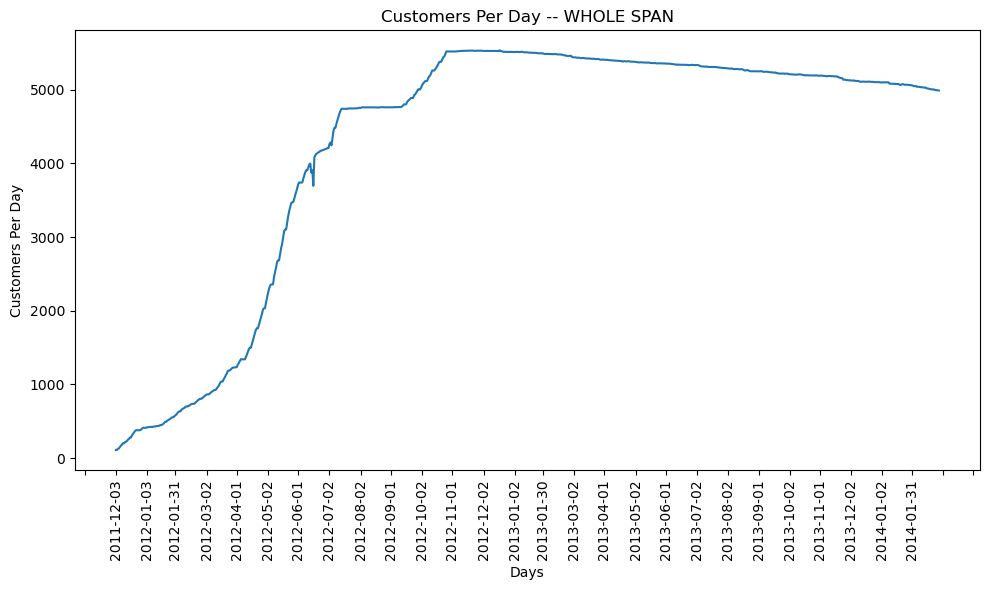

In [24]:
import matplotlib.dates as mdates

def plotCustomersPerDay(days):

    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.plot(days.index, days)

    # Set x-axis ticks to show once a month
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    plt.xlabel('Days')
    plt.ylabel('Customers Per Day')
    plt.title('Customers Per Day -- WHOLE SPAN')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()

plotCustomersPerDay(allDays)


In [4]:
import pandas as pd

allDays = pd.read_pickle("Data/pickles/allDays.pkl")

def findDips(allDays, dropAmount):
    # Create a new DataFrame to store dips
    dipDays = allDays.copy()
    
    # Identify dips where the next day drops by an amount
    dipDays[(dipDays.shift(-1) > dipDays + dropAmount)] = pd.NA
    
    # Find the rows where dips occur
    nanRows = dipDays[dipDays.isna()].index

    print("Days where the number of customers drops by at least {} customers: \n{}".format(dropAmount, nanRows.values)) 
    
    return nanRows

dipRows = findDips(allDays, 100)
dipRows = findDips(allDays, 50)

dipDays = pd.DataFrame()
dipDays["day"] = dipRows
dipDays.to_csv("dipDays.csv")

Days where the number of customers drops by at least 100 customers: 
['2012-05-07' '2012-06-16' '2012-07-04']
Days where the number of customers drops by at least 50 customers: 
['2012-04-16' '2012-04-26' '2012-04-29' '2012-04-30' '2012-05-01'
 '2012-05-02' '2012-05-07' '2012-05-08' '2012-05-09' '2012-05-10'
 '2012-05-13' '2012-05-14' '2012-05-15' '2012-05-16' '2012-05-17'
 '2012-05-20' '2012-05-21' '2012-05-22' '2012-05-23' '2012-05-24'
 '2012-05-28' '2012-05-30' '2012-06-16' '2012-07-01' '2012-07-04'
 '2012-07-05' '2012-07-08']


## Power Outage Days

In [26]:
# There are possibly 15,138 power outages, where max energy was 0 for the day
zeroPower = londonData[londonData['energy_max'] == 0]
zeroPower.shape

(15069, 9)

In [27]:
# I wonder what energy_count is????
zeroPower.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
12271,MAC004560,2013-04-02,0.0,0.0,0.0,48,0.0,0.0,0.0
12272,MAC004560,2013-04-03,0.0,0.0,0.0,48,0.0,0.0,0.0
12273,MAC004560,2013-04-04,0.0,0.0,0.0,48,0.0,0.0,0.0
12274,MAC004560,2013-04-05,0.0,0.0,0.0,1,NaN,0.0,0.0
41810,MAC001340,2013-11-15,0.0,0.0,0.0,48,0.0,0.0,0.0


In [28]:
zeroPower.to_csv("PowerOutages.csv")

In [29]:
# Convert to datetime
zeroPower['day'] = pd.to_datetime(zeroPower['day'])

C:\Users\brely\AppData\Local\Temp\ipykernel_4052\2167483632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zeroPower['day'] = pd.to_datetime(zeroPower['day'])


In [30]:
# There are possibly 819 days where the power was out for at least one location
# After dropping NaN and Days and Customers <= 100, this became 814.
zeroPowerDays = zeroPower.groupby("day").count()
zeroPowerDays.drop(zeroPowerDays.columns.difference(['LCLid']), axis=1, inplace=True)
zeroPowerDays.shape

(814, 1)

In [31]:
zeroPowerDays.head()

,LCLid
day,
2011-12-04,1
2011-12-05,1
2011-12-06,1
2011-12-07,1
2011-12-08,1


In [32]:
zeroPowerDays.tail()

,LCLid
day,
2014-02-23,22
2014-02-24,19
2014-02-25,20
2014-02-26,21
2014-02-27,21


In [33]:
# There was a day where 37 customers were without power - that's the largest spread of a blackout
# There was also a day where 1 person was without power - that's the smallest spread of a blackout
zeroPowerDays.describe()

,LCLid
count,814.000000
mean,18.512285
std,9.153157
min,1.000000
25%,13.000000
50%,21.000000
75%,25.000000
max,37.000000


In [34]:
# There were 104 customers affected by a small outage of fewer than 4 customers
smallOutages = zeroPowerDays[zeroPowerDays["LCLid"] < 4].index
smallOutages.shape

(103,)

In [35]:
# There were 447 customers affected by larger outages of more than 20 customers
zeroPowerDays[zeroPowerDays["LCLid"] > 20].index.size

450

In [36]:
# There were 42 customers affected by larger outages of more than 30 customers
largeOutages = zeroPowerDays[zeroPowerDays["LCLid"] > 30].index
largeOutages.shape

(44,)

In [37]:
largeOutages

DatetimeIndex(['2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31', '2013-01-01', '2013-01-02',
               '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06',
               '2013-01-07', '2013-02-23', '2013-05-19', '2013-06-30',
               '2013-07-21', '2013-07-28', '2013-08-11', '2013-08-18',
               '2013-08-24', '2013-08-25', '2013-08-26', '2013-09-01',
               '2013-09-07', '2013-09-08', '2013-09-14', '2013-09-15',
               '2013-12-15', '2013-12-21', '2013-12-22', '2013-12-25',
               '2013-12-26', '2013-12-28', '2013-12-29', '2013-12-30',
               '2013-12-31', '2014-01-01', '2014-01-04', '2014-01-05'],
              dtype='datetime64[ns]', name='day', freq=None)

### Outages Per Year

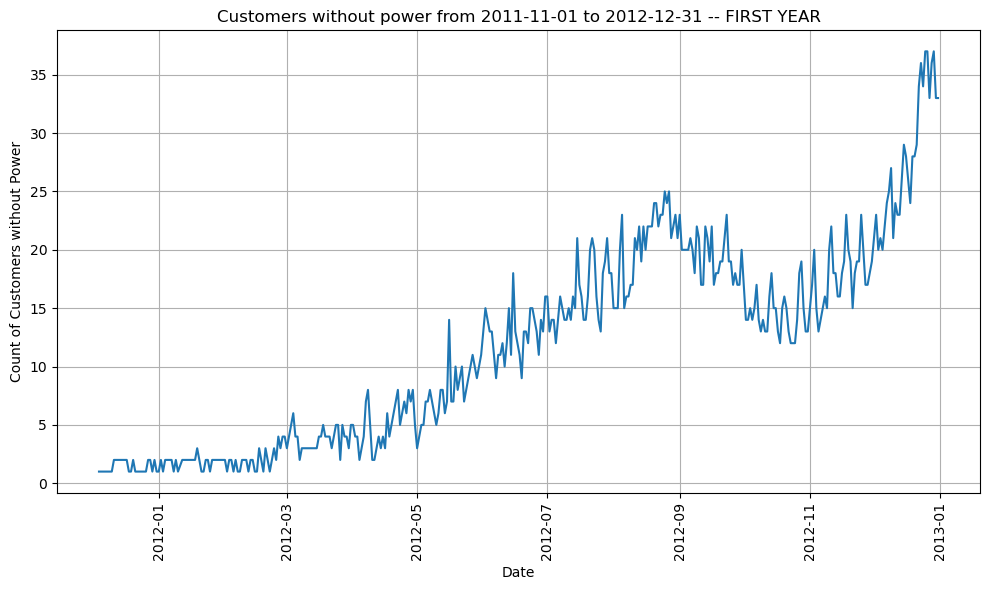

In [38]:


def plotOutages(start_date, end_date, title):
    # Filter the DataFrame to include only the rows within the specified date range
    subset_data = zeroPowerDays[start_date:end_date]

    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.plot(subset_data.index, subset_data['LCLid'])
    plt.xlabel('Date')
    plt.ylabel('Count of Customers without Power')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

start_date = '2011-11-01'
end_date = '2012-12-31'
title = 'Customers without power from {} to {} -- FIRST YEAR'.format(start_date, end_date)
plotOutages(start_date, end_date, title)

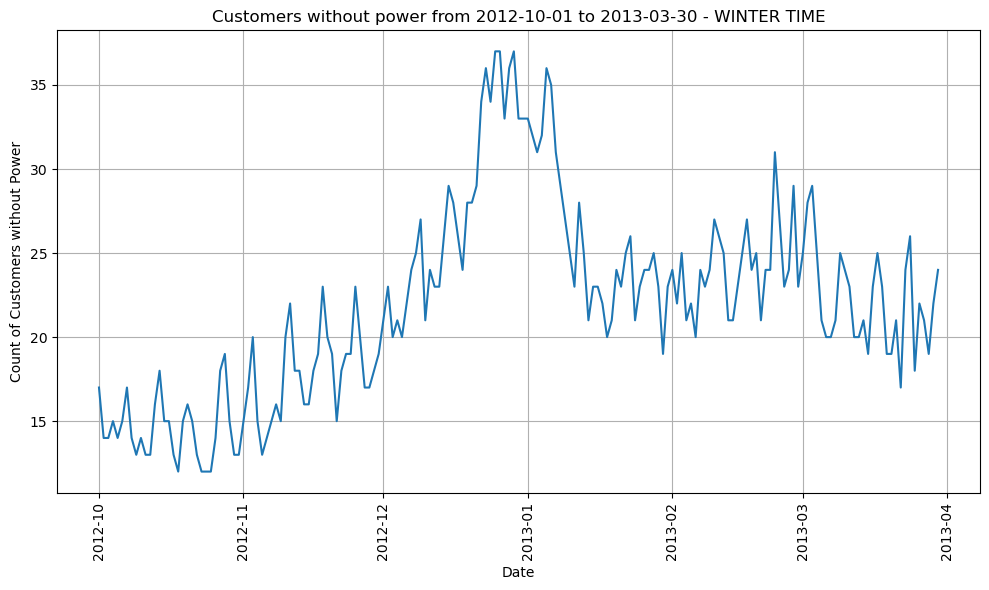

In [39]:
start_date = '2012-10-01'
end_date = '2013-03-30'
title = 'Customers without power from {} to {} - WINTER TIME'.format(start_date, end_date)
plotOutages(start_date, end_date, title)


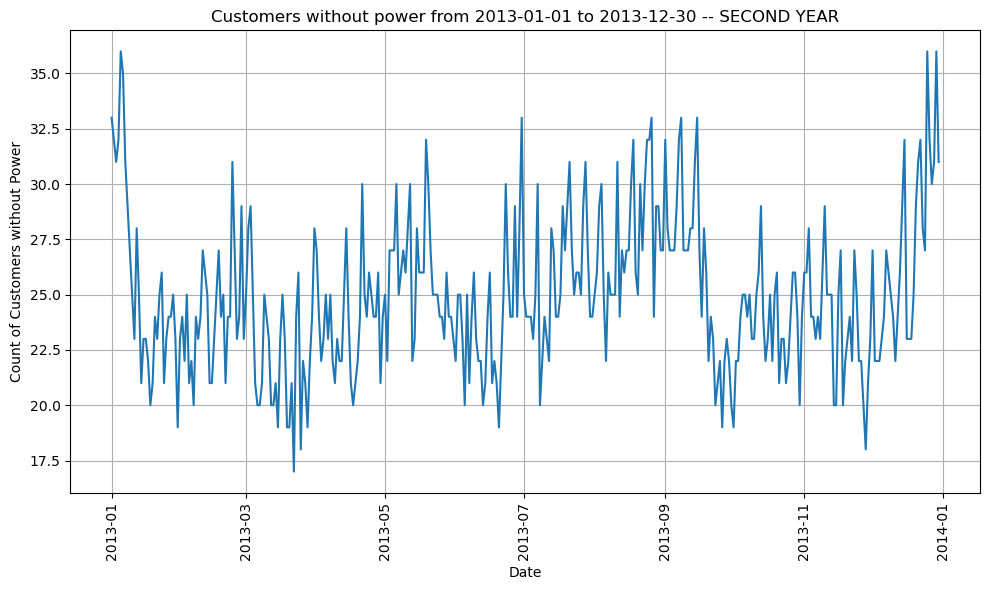

In [40]:
start_date = '2013-01-01'
end_date = '2013-12-30'
title = 'Customers without power from {} to {} -- SECOND YEAR'.format(start_date, end_date)
plotOutages(start_date, end_date, title)


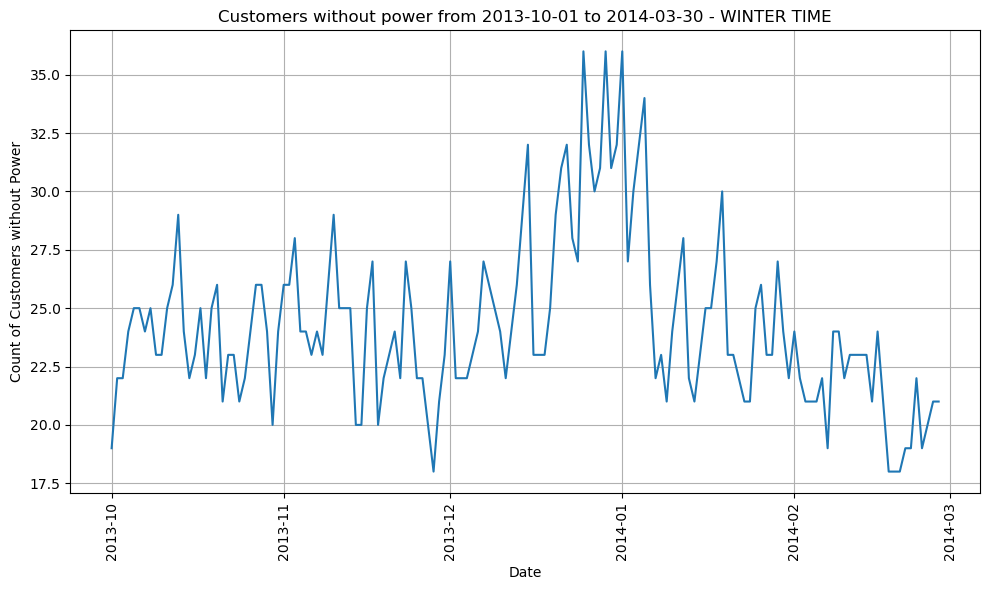

In [41]:
start_date = '2013-10-01'
end_date = '2014-03-30'
title = 'Customers without power from {} to {} - WINTER TIME'.format(start_date, end_date)
plotOutages(start_date, end_date, title)

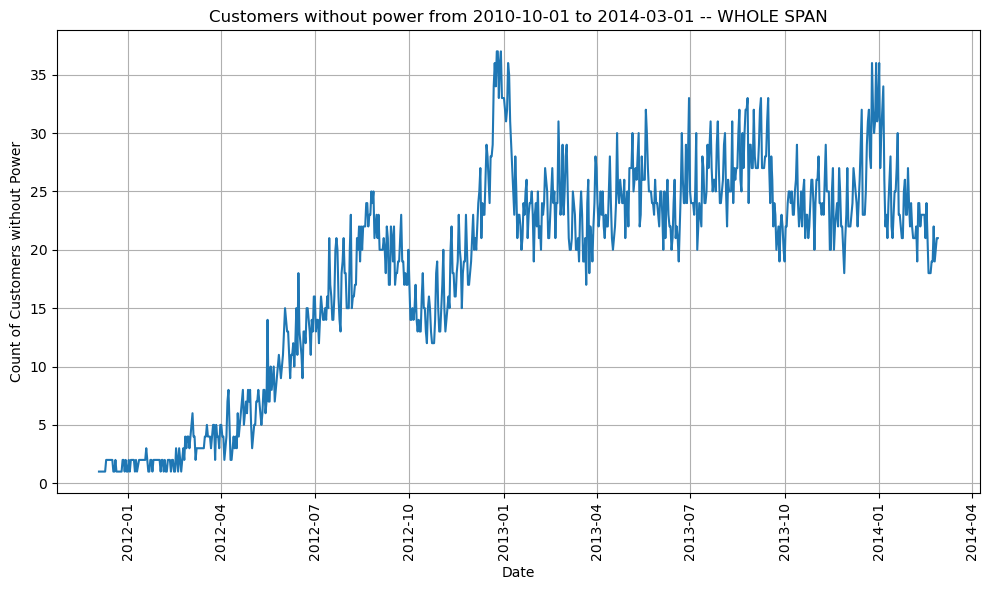

In [42]:
start_date = '2010-10-01'
end_date = '2014-03-01'
title = 'Customers without power from {} to {} -- WHOLE SPAN'.format(start_date, end_date)
plotOutages(start_date, end_date, title)

### Power Outage Customers

In [43]:
# There are possibly 281 customers affected by at least 1 power outage over the whole data collection period
# This went down to 225 after additional pre-processing.
zeroPowerIDs = zeroPower.groupby("LCLid").count()
zeroPowerIDs.shape

(254, 8)

In [44]:
# Keep only the "day" column
zeroPowerIDs.drop(zeroPowerIDs.columns.difference(['day']), axis=1, inplace=True)
zeroPowerIDs.head()


,day
LCLid,
MAC000004,1
MAC000037,640
MAC000041,17
MAC000042,30
MAC000120,11


In [45]:
zeroPowerIDs.describe()

,day
count,254.000000
mean,59.326772
std,117.598330
min,1.000000
25%,4.000000
50%,17.500000
75%,59.750000
max,782.000000


<Figure size 1000x600 with 0 Axes>

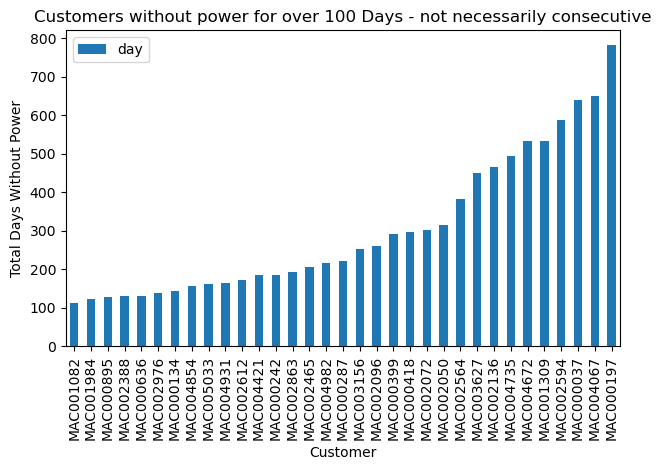

In [46]:


zeroPowerIDs = zeroPowerIDs.sort_values(by="day")

def plotCustomers(data, title):
    plt.figure(figsize=(10, 6))
    data.plot(kind='bar')
    plt.xlabel('Customer')
    plt.ylabel('Total Days Without Power')
    plt.title(title)
    plt.xticks(rotation=90)  # Rotating x-axis labels for better visibility
    plt.tight_layout()
    plt.show()

zeroPowerIDs_filtered = zeroPowerIDs[zeroPowerIDs['day'] > 100]
title = 'Customers without power for over 100 Days - not necessarily consecutive'
plotCustomers(zeroPowerIDs_filtered, title)

In [47]:
# There are 33 customers who have over 100 days of power outage during the data collection period.
zeroPowerIDs_filtered.shape

(33, 1)

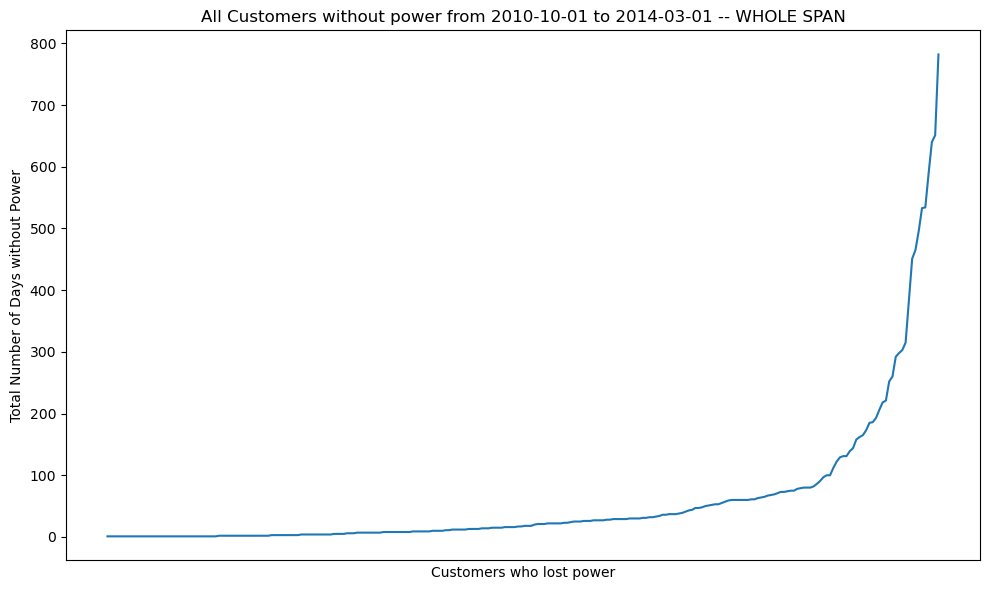

In [48]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(zeroPowerIDs.index, zeroPowerIDs["day"])
plt.xlabel('Customers who lost power')
plt.ylabel('Total Number of Days without Power')
plt.title('All Customers without power from {} to {} -- WHOLE SPAN'.format(start_date, end_date))
plt.xticks([])
plt.tight_layout()
plt.show()

In [49]:
zeroPower.sort_values(by=['day'], inplace=True)

C:\Users\brely\AppData\Local\Temp\ipykernel_4052\3317076614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zeroPower.sort_values(by=['day'], inplace=True)


In [50]:
zeroPower.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
2127701,MAC000197,2011-12-04,0.0,0.0,0.0,48,0.0,0.0,0.0
2127702,MAC000197,2011-12-05,0.0,0.0,0.0,48,0.0,0.0,0.0
2127703,MAC000197,2011-12-06,0.0,0.0,0.0,48,0.0,0.0,0.0
2127704,MAC000197,2011-12-07,0.0,0.0,0.0,48,0.0,0.0,0.0
2127705,MAC000197,2011-12-08,0.0,0.0,0.0,48,0.0,0.0,0.0


In [51]:
zeroPower.tail()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
1216846,MAC002607,2014-02-27,0.0,0.0,0.0,48,0.0,0.0,0.0
3364418,MAC002612,2014-02-27,0.0,0.0,0.0,48,0.0,0.0,0.0
548823,MAC000042,2014-02-27,0.0,0.0,0.0,48,0.0,0.0,0.0
2338052,MAC004421,2014-02-27,0.0,0.0,0.0,48,0.0,0.0,0.0
3314707,MAC004982,2014-02-27,0.0,0.0,0.0,48,0.0,0.0,0.0


## Customer Information

In [4]:
import pandas as pd
path = "data/archive/"
house = pd.read_csv(path + 'informations_households.csv')

In [5]:
house.shape

(5566, 5)

In [6]:
house.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [56]:
house.groupby("stdorToU").count()

,LCLid,Acorn,Acorn_grouped,file
stdorToU,,,,
Std,4443,4443,4443,4443
ToU,1123,1123,1123,1123


In [8]:
house.groupby("Acorn").count()

,LCLid,stdorToU,Acorn_grouped,file
Acorn,,,,
ACORN-,2,2,2,2
ACORN-A,157,157,157,157
ACORN-B,25,25,25,25
ACORN-C,151,151,151,151
ACORN-D,292,292,292,292
ACORN-E,1567,1567,1567,1567
ACORN-F,684,684,684,684
ACORN-G,205,205,205,205
ACORN-H,455,455,455,455


In [7]:
# There are more people in the Affluent category, but some in Adversity or Comfortable too.
house.groupby("Acorn_grouped").count()

,LCLid,stdorToU,Acorn,file
Acorn_grouped,,,,
ACORN-,2,2,2,2
ACORN-U,49,49,49,49
Adversity,1816,1816,1816,1816
Affluent,2192,2192,2192,2192
Comfortable,1507,1507,1507,1507


### Customers Affected on Dec 22, 2012
I am just picking one day of outages to examine

In [57]:
def getcustomersBlackedOutForDayDf(dayToExamine):
    oneMajorOutageDay = londonData[londonData["day"] == dayToExamine]
    print("Customers who have data rows for that day: {}".format(oneMajorOutageDay.shape[0]))

    # These are the customers who had an outage that day
    return oneMajorOutageDay[oneMajorOutageDay["energy_max"] == 0]

dayToExamine = "2012-12-22"
customersBlackedOutDf = getcustomersBlackedOutForDayDf(dayToExamine)
customersBlackedOutDf

Customers who have data rows for that day: 5516


,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
182225,MAC001082,2012-12-22,0.0,0.0,0.0,48,0.0,0.0,0.0
464319,MAC004292,2012-12-22,0.0,0.0,0.0,48,0.0,0.0,0.0
513795,MAC000242,2012-12-22,0.0,0.0,0.0,48,0.0,0.0,0.0
533539,MAC004854,2012-12-22,0.0,0.0,0.0,48,0.0,0.0,0.0
602194,MAC001051,2012-12-22,0.0,0.0,0.0,48,0.0,0.0,0.0
845826,MAC002224,2012-12-22,0.0,0.0,0.0,48,0.0,0.0,0.0
915020,MAC002050,2012-12-22,0.0,0.0,0.0,48,0.0,0.0,0.0
963625,MAC001348,2012-12-22,0.0,0.0,0.0,48,0.0,0.0,0.0
989027,MAC003207,2012-12-22,0.0,0.0,0.0,48,0.0,0.0,0.0
1215216,MAC002594,2012-12-22,0.0,0.0,0.0,48,0.0,0.0,0.0


In [58]:
# I will pick five of them and look closer at their patterns
def getSubsetOfCustomers(customersBlackedOutDf, start, end, step):
    return customersBlackedOutDf['LCLid'][start:end:step]

subsetOfcustomersBlackedOutDf = getSubsetOfCustomers(customersBlackedOutDf, 5, 10, 1)
subsetOfcustomersBlackedOutDf.head()

845826     MAC002224
915020     MAC002050
963625     MAC001348
989027     MAC003207
1215216    MAC002594
Name: LCLid, dtype: object

In [59]:
# Find the blocks that pertain to those 5 houses
blocksOfOutages = []
for customer in subsetOfcustomersBlackedOutDf:
    blocksOfOutages.append(str(house[house["LCLid"] == customer]["file"].values[0]))

blocksOfOutages


['block_19', 'block_10', 'block_111', 'block_90', 'block_109']

In [60]:
# Retrieve the data from the blocks that have that information

def getDataFromBlocks(blocksOfOutages):
    path = "data/archive/hhblock_dataset/hhblock_dataset/" 

    blocksOfOutagesdf = pd.DataFrame()

    for block in blocksOfOutages:
        df1 = pd.read_csv(path + block + '.csv')
        blocksOfOutagesdf = pd.concat([df1, blocksOfOutagesdf], ignore_index = True) 
        blocksOfOutagesdf.reset_index() 

    return blocksOfOutagesdf

blocksOfOutagesdf = getDataFromBlocks(blocksOfOutages)
blocksOfOutagesdf.shape

(134067, 50)

In [61]:
import matplotlib.pyplot as plt

# Initialize min and max values for y-axis
y_min = 0
y_max = 4

def plotDayConsumptionLine(data, customers, day):
    global y_min, y_max  # Use global variables to track min and max values

    # Grab only the information from that day
    oneDay = data[data["day"] == day]
    toPlot = oneDay[oneDay["LCLid"].isin(customers)]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Iterate over rows of the DataFrame
    for idx, row in toPlot.iterrows():
        # Plot each row as a separate line with a different color
        ax.plot(row.index[2:], row.values[2:], label=f'LCLid: {row["LCLid"]}')
        
        # Update min and max values for y-axis
        y_min = min(y_min, row.values[2:].min())
        y_max = max(y_max, row.values[2:].max())

    # Set y-axis limits based on min and max values
    ax.set_ylim(y_min, y_max)

    # Set x-axis labels to the "hh_" columns
    ax.set_xticks(range(len(toPlot.columns[2:])))
    ax.set_xticklabels(toPlot.columns[2:], rotation=90)

    # Set labels and title
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Power (kWh/hh)')
    ax.set_title('Power Consumption of Customers on {}'.format(day))

    # Add legend
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()


In [62]:
plotDayConsumptionLine(londonDataSortedByDay, subsetOfcustomersBlackedOutDf, "2012-04-04")

NameError: name 'londonDataSortedByDay' is not defined

c:\Users\brely\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\brely\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


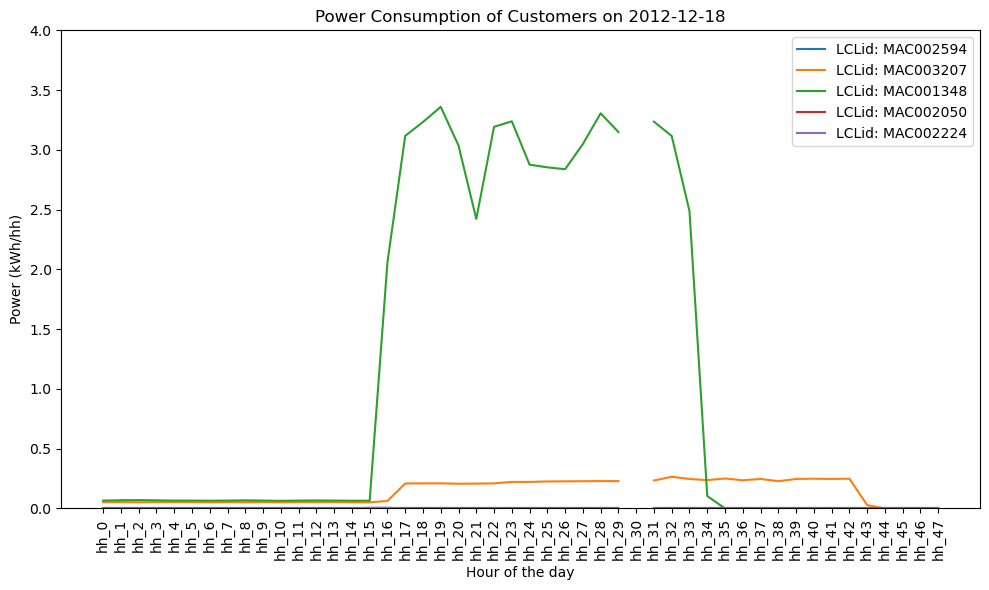

In [ ]:
plotDayConsumptionLine(blocksOfOutagesdf, subsetOfcustomersBlackedOutDf, "2012-12-18")

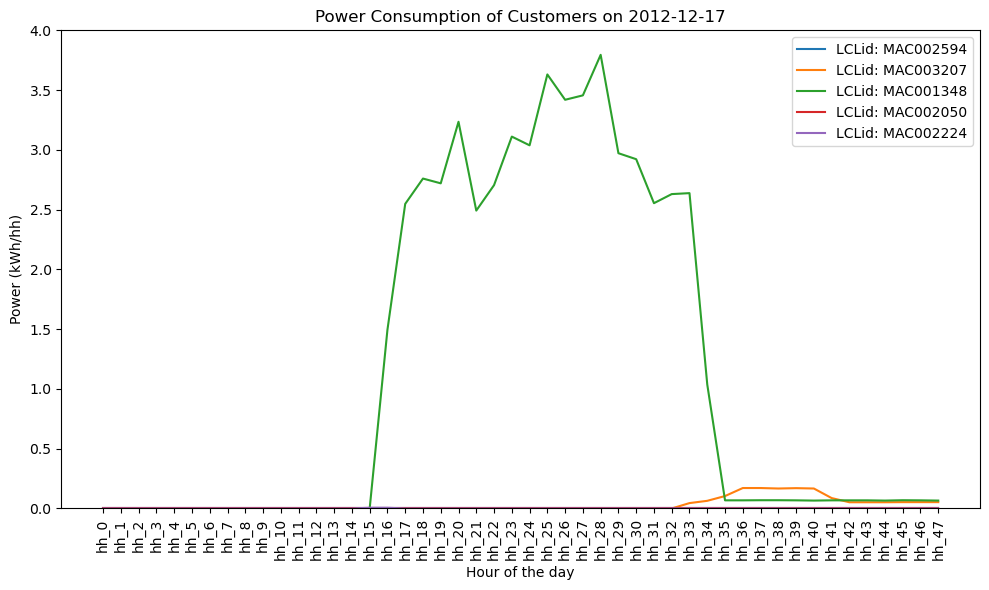

In [ ]:
plotDayConsumptionLine(blocksOfOutagesdf, subsetOfcustomersBlackedOutDf, "2012-12-17")

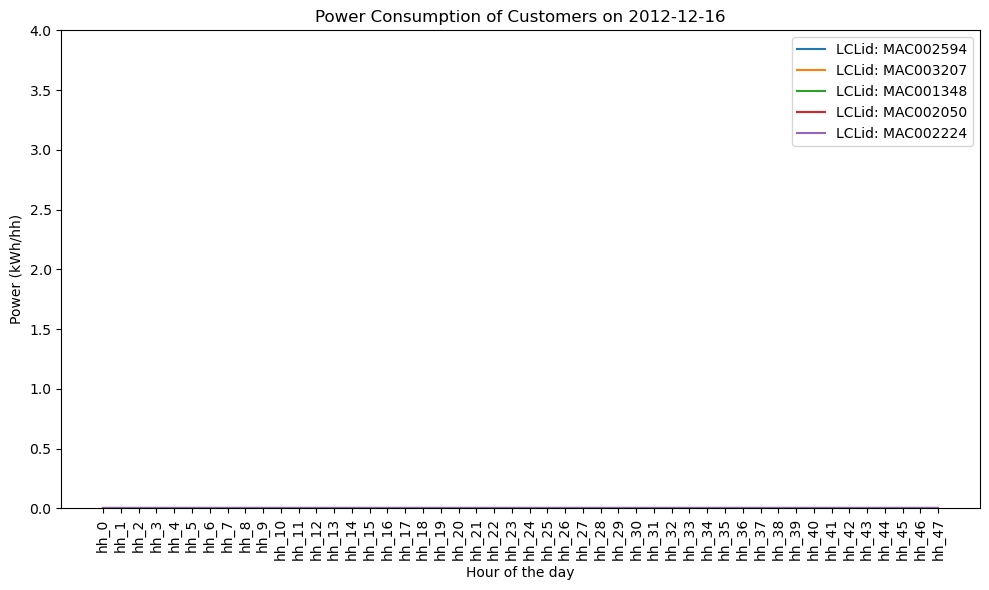

In [ ]:
plotDayConsumptionLine(blocksOfOutagesdf, subsetOfcustomersBlackedOutDf, "2012-12-16")

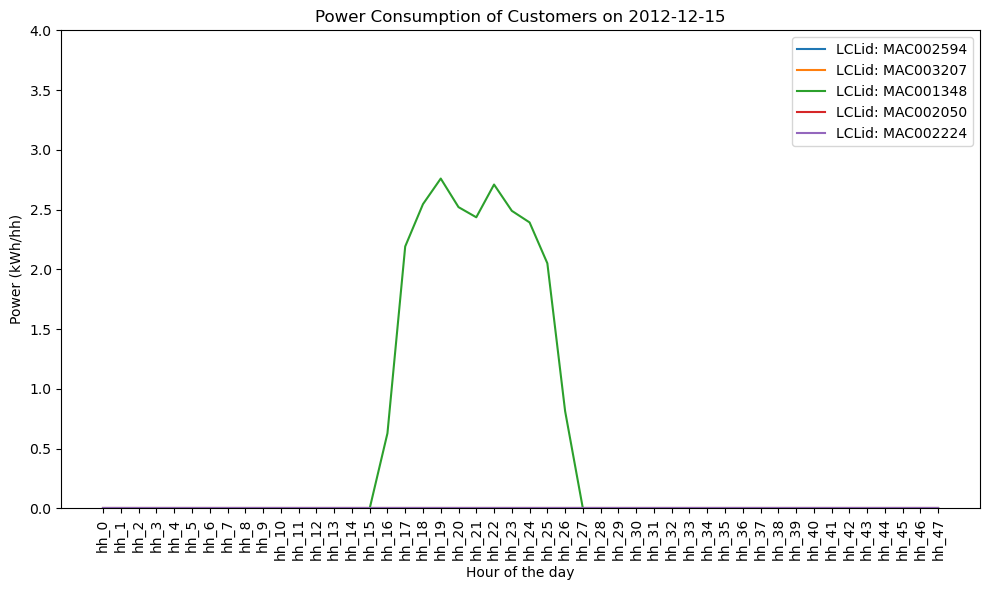

In [ ]:
plotDayConsumptionLine(blocksOfOutagesdf, subsetOfcustomersBlackedOutDf, "2012-12-15")

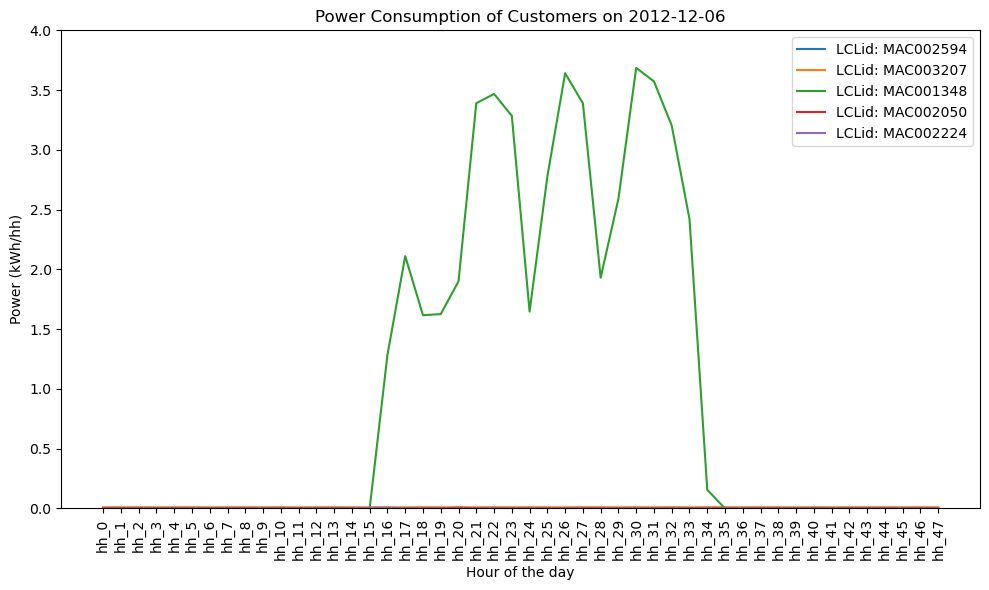

In [ ]:
plotDayConsumptionLine(blocksOfOutagesdf, subsetOfcustomersBlackedOutDf, "2012-12-06")

## Read in ALL hh hourly data

In [ ]:
import pandas as pd
import glob

def readAllHHData():
    # Read all CSV files and concatenate them into a single DataFrame
    path = "data/archive/hhblock_dataset/hhblock_dataset/" 

    all_files = glob.glob(path + "block_*.csv")
    df_list = []
    for filename in all_files:
        df = pd.read_csv(filename)
        df_list.append(df)
    full_df = pd.concat(df_list)

    londonDataSortedByDay = full_df.sort_values(by='day')
    londonDataSortedByDay.dropna(inplace=True)

    return londonDataSortedByDay

londonDataSortedByDay = readAllHHData()
londonDataSortedByDay.head()


,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000155,2011-11-24,0.256,0.171,0.176,0.218,0.205,0.215,0.227,0.230,...,0.703,0.955,0.730,0.560,0.625,0.786,0.542,0.757,0.442,0.226
1605,MAC000151,2011-11-24,0.027,0.026,0.027,0.026,0.060,0.050,0.026,0.026,...,0.164,0.156,0.153,0.152,0.268,0.182,0.183,0.129,0.045,0.038
0,MAC000147,2011-11-24,0.271,0.176,0.118,0.115,0.114,0.111,0.055,0.048,...,0.269,0.495,0.469,0.444,0.390,0.293,0.358,0.171,0.299,0.180
2422,MAC000157,2011-11-24,0.388,0.428,0.323,0.334,0.330,0.175,0.186,0.253,...,0.292,0.324,0.261,0.230,0.316,0.290,0.258,0.349,0.340,0.295
824,MAC000153,2011-11-24,0.408,2.159,1.952,1.714,0.743,0.277,0.315,0.459,...,0.718,0.567,0.668,0.615,1.019,0.580,1.056,0.878,0.686,0.609


In [ ]:
# Oh, boy! There are a lot more null values than I thought, but I think these may be important.
# Might signal an outage
nan_values = londonDataSortedByDay.isna()
nan_values.shape

(3463866, 50)

### Customers Affected on April 5, 2012

In [ ]:
def examineInterestingDay(dayToExamine):

    # Customers who had an outage that day
    customersBlackedOutDf = getcustomersBlackedOutForDayDf(dayToExamine)
    numberOfBlackouts = customersBlackedOutDf.shape[0]
    print("Number of customers with total blackout on {}: {}".format(dayToExamine, numberOfBlackouts))
    print("------------")
    print(londonData[londonData["day"] == dayToExamine].describe(()))


In [ ]:
dayToExamine = "2012-04-05"
examineInterestingDay(dayToExamine)


Customers who have data rows for that day: 1341
Number of customers with total blackout on 2012-04-05: 3
------------
       energy_median  energy_mean   energy_max  energy_count   energy_std  \
count    1341.000000  1341.000000  1341.000000   1341.000000  1340.000000   
mean        0.164315     0.223831     0.905874     47.505593     0.191160   
std         0.167659     0.193039     0.790692      3.051450     0.181717   
min         0.000000     0.000000     0.000000      1.000000     0.000000   
50%         0.116500     0.166208     0.706000     48.000000     0.133199   
max         1.366500     1.499604     5.730000     48.000000     1.372008   

        energy_sum   energy_min  
count  1341.000000  1341.000000  
mean     10.645233     0.058257  
std       9.232636     0.075748  
min       0.000000     0.000000  
50%       7.946000     0.038000  
max      71.981000     0.880000  


Customers with NaN values for 2012-04-05: 0
Customers with Zero power for 2012-04-05: 42


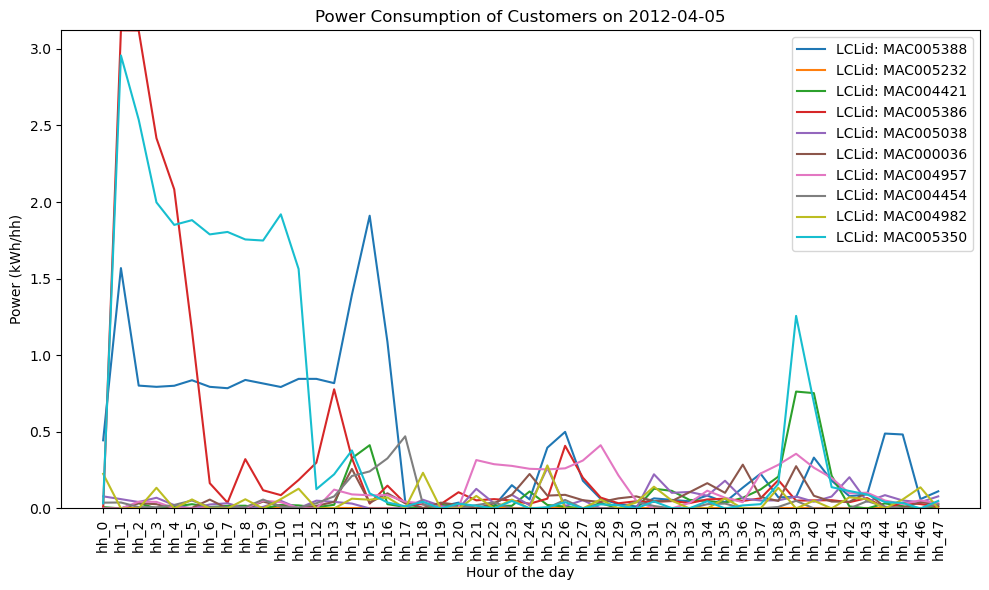

In [ ]:
def getCustomersAffectedByOutage(day):
    oneDay = londonDataSortedByDay[londonDataSortedByDay["day"] == dayToExamine]
    nanBoolean = oneDay.isna()
    nanRows = nanBoolean[nanBoolean['LCLid'] == True]

    print("Customers with NaN values for {}: {}".format(day, nanRows.shape[0]))
    zeroRows = oneDay[(oneDay == 0).any(axis=1)]

    print("Customers with Zero power for {}: {}".format(day, zeroRows.shape[0]))

    return zeroRows["LCLid"]

lostPower = getCustomersAffectedByOutage(dayToExamine)
lostPowerSubset = lostPower[0:10]

y_min = 0
y_max = 2.5
plotDayConsumptionLine(londonDataSortedByDay, lostPowerSubset, dayToExamine)

Customers with NaN values for 2012-04-05: 0
Customers with Zero power for 2012-04-05: 42


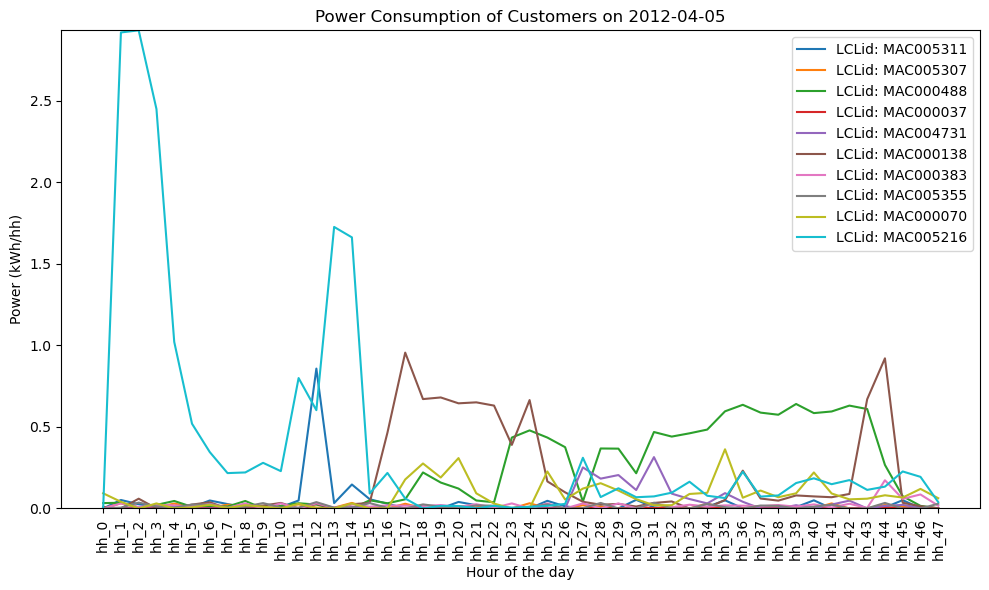

In [ ]:
lostPower = getCustomersAffectedByOutage(dayToExamine)
lostPowerSubset = lostPower[10:20]

y_min = 0
y_max = 2.5
plotDayConsumptionLine(londonDataSortedByDay, lostPowerSubset, dayToExamine)

In [ ]:
import matplotlib.pyplot as plt

# Initialize min and max values for y-axis
y_min = 0
y_max = 4

def plotDayConsumptionBar(data, customers, day):
    global y_min, y_max  # Use global variables to track min and max values

    # Grab only the information from that day
    oneDay = data[data["day"] == day]
    toPlot = oneDay[oneDay["LCLid"].isin(customers)]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Iterate over rows of the DataFrame
    for idx, row in toPlot.iterrows():
        # Plot each row as a separate bar with a different color
        ax.bar(row.index[2:], row.values[2:], label=f'LCLid: {row["LCLid"]}')
        
        # Update min and max values for y-axis
        y_min = min(y_min, row.values[2:].min())
        y_max = max(y_max, row.values[2:].max())

    # Set y-axis limits based on min and max values
    ax.set_ylim(y_min, y_max)

    # Set x-axis labels to the "hh_" columns
    ax.set_xticks(range(len(toPlot.columns[2:])))
    ax.set_xticklabels(toPlot.columns[2:], rotation=90)

    # Set labels and title
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Power (kWh/hh)')
    ax.set_title('Power Consumption of Customers on {}'.format(day))

    # Add legend
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()


Customers with NaN values for 2012-04-05: 0
Customers with Zero power for 2012-04-05: 42


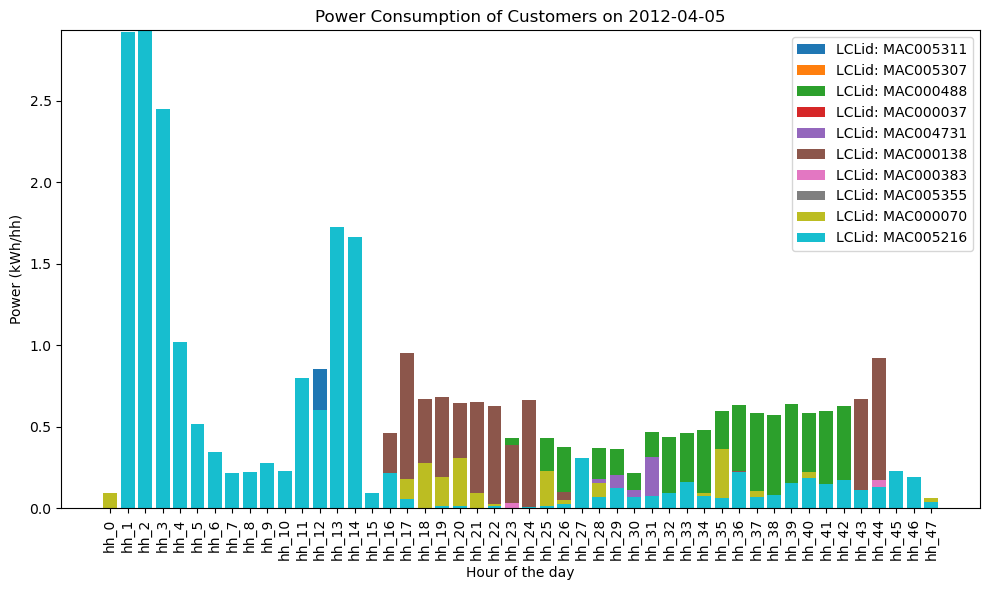

In [ ]:
lostPower = getCustomersAffectedByOutage(dayToExamine)
lostPowerSubset = lostPower[10:20]

y_min = 0
y_max = 2.5
plotDayConsumptionBar(londonDataSortedByDay, lostPowerSubset, dayToExamine)

### Customers Affected on April 12, 2012

Customers who have data rows for that day: 1443
Number of customers with total blackout on 2012-04-12: 3
------------
       energy_median  energy_mean   energy_max  energy_count   energy_std  \
count    1443.000000  1443.000000  1443.000000   1443.000000  1443.000000   
mean        0.154361     0.213085     0.879420     47.431046     0.182153   
std         0.155308     0.180877     0.741236      3.410424     0.170757   
min         0.000000     0.000000     0.000000     20.000000     0.000000   
50%         0.110000     0.159604     0.689000     48.000000     0.129082   
max         1.850500     1.962021     6.212000     48.000000     1.394703   

        energy_sum   energy_min  
count  1443.000000  1443.000000  
mean     10.115362     0.058957  
std       8.665063     0.083705  
min       0.000000     0.000000  
50%       7.498000     0.038000  
max      94.177000     1.633000  
Customers with NaN values for 2012-04-12: 0
Customers with Zero power for 2012-04-12: 56


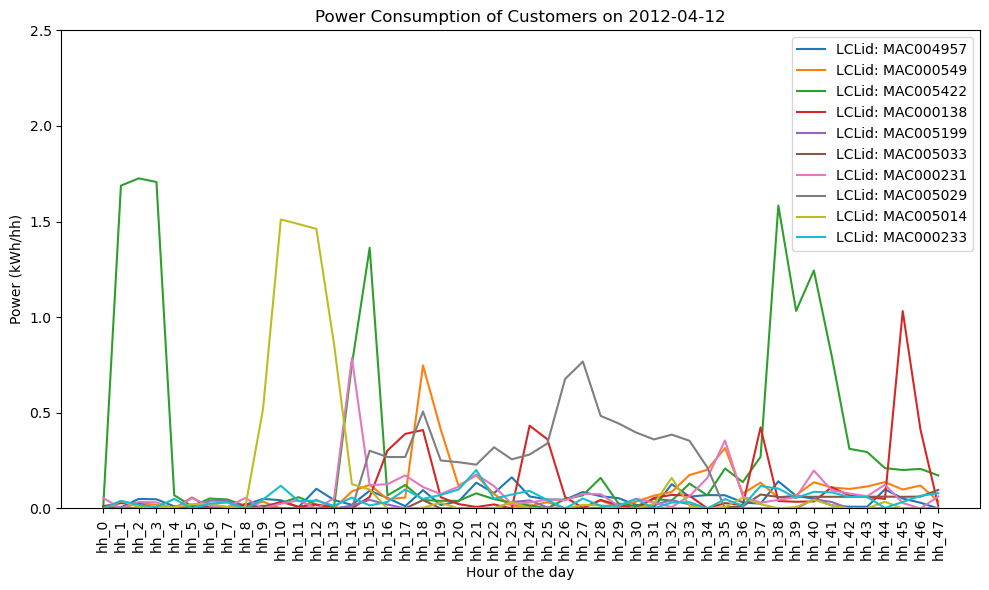

In [ ]:
dayToExamine = "2012-04-12"
examineInterestingDay(dayToExamine)

lostPower = getCustomersAffectedByOutage(dayToExamine)
lostPowerSubset = lostPower[10:20]

y_min = 0
y_max = 2.5
plotDayConsumptionLine(londonDataSortedByDay, lostPowerSubset, dayToExamine)

### Customers Affected on July 10 2012

Customers who have data rows for that day: 4590
Number of customers with total blackout on 2012-07-10: 14
------------
       energy_median  energy_mean   energy_max  energy_count   energy_std  \
count    4590.000000  4590.000000  4590.000000   4590.000000  4589.000000   
mean        0.130251     0.174813     0.735995     47.765795     0.144964   
std         0.118278     0.136036     0.564267      2.244056     0.117028   
min         0.000000     0.000000     0.000000      1.000000     0.000000   
50%         0.101500     0.142271     0.605500     48.000000     0.113419   
max         2.674500     2.287542     4.813000     48.000000     1.129984   

        energy_sum   energy_min  
count  4590.000000  4590.000000  
mean      8.334663     0.052574  
std       6.460558     0.057691  
min       0.000000     0.000000  
50%       6.778000     0.038000  
max     109.802000     1.058000  
Customers with NaN values for 2012-07-10: 0
Customers with Zero power for 2012-07-10: 182


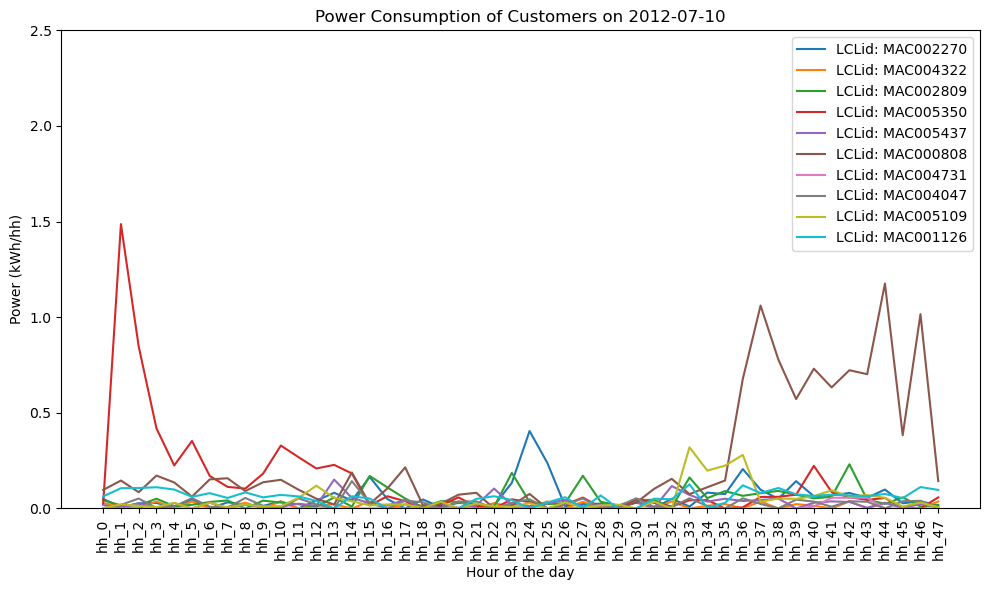

In [ ]:
dayToExamine = "2012-07-10"
examineInterestingDay(dayToExamine)

lostPower = getCustomersAffectedByOutage(dayToExamine)
lostPowerSubset = lostPower[10:20]

y_min = 0
y_max = 2.5
plotDayConsumptionLine(londonDataSortedByDay, lostPowerSubset, dayToExamine)

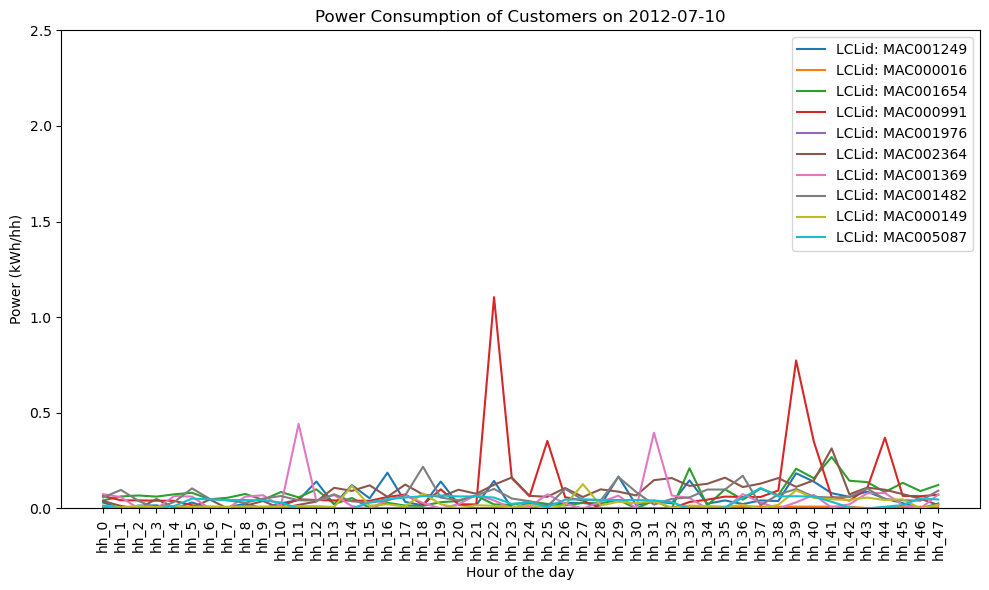

In [ ]:
lostPowerSubset = lostPower[20:30]

y_min = 0
y_max = 2.5
plotDayConsumptionLine(londonDataSortedByDay, lostPowerSubset, dayToExamine)

### Customers Affected on May 

### Dead House

In [ ]:
deadHouseID = "MAC001082"

# Looking at that house that was dead for a long time
def deadHouseInfo(deadHouseID):

    deadHouse = londonDataSortedByDay[londonDataSortedByDay["LCLid"] == "MAC001082"]
    deadHouse.set_index(deadHouse['day'], inplace=True)
    deadHouse.drop("LCLid", axis=1, inplace=True)
    deadHouse.drop("day", axis=1, inplace=True)
    return deadHouse

deadHouse = deadHouseInfo(deadHouseID)

C:\Users\brely\AppData\Local\Temp\ipykernel_41976\3857337313.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deadHouse.drop("LCLid", axis=1, inplace=True)
C:\Users\brely\AppData\Local\Temp\ipykernel_41976\3857337313.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deadHouse.drop("day", axis=1, inplace=True)


             hh_0   hh_1   hh_2   hh_3   hh_4   hh_5   hh_6   hh_7   hh_8  \
day                                                                         
2012-11-01  0.000  0.022  0.000  0.017  0.007  0.000  0.025  0.000  0.026   
2012-11-02  0.010  0.014  0.000  0.023  0.000  0.024  0.000  0.009  0.014   
2012-11-03  0.000  0.022  0.000  0.023  0.000  0.002  0.022  0.000  0.024   
2012-11-04  0.000  0.024  0.000  0.023  0.001  0.000  0.026  0.000  0.022   
2012-11-05  0.008  0.000  0.024  0.000  0.009  0.014  0.000  0.023  0.000   
2012-11-06  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2012-11-07  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2012-11-08  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2012-11-09  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2012-11-10  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2012-11-11  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   

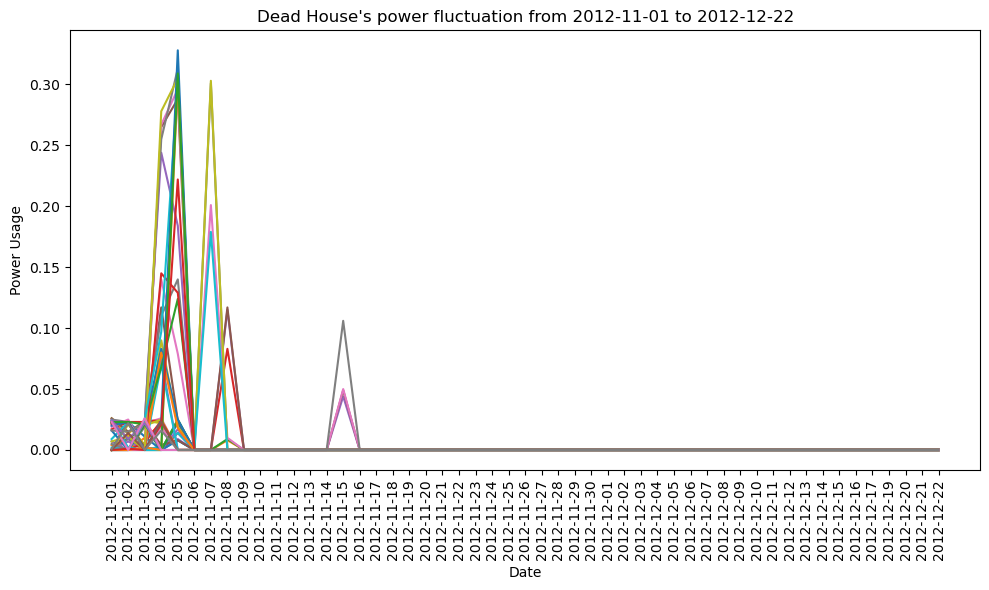

In [ ]:
# Filter the DataFrame to include only the rows within the specified date range
start_date = '2012-11-01'
end_date = '2012-12-22'

def plotDeadHouseData(start_date, end_date):
    subset_data = deadHouse[start_date:end_date]
    print(subset_data)

    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.plot(subset_data)
    plt.xlabel('Date')
    plt.ylabel('Power Usage')
    plt.title('Dead House\'s power fluctuation from {} to {}'.format(start_date, end_date))
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plotDeadHouseData(start_date, end_date)

### Dead House 2

In [ ]:
house[house["LCLid"] == "MAC000197"]

,LCLid,stdorToU,Acorn,Acorn_grouped,file
2399,MAC000197,Std,ACORN-F,Comfortable,block_47


In [ ]:
path = "data/archive/hhblock_dataset/hhblock_dataset/"
halfblock47 = pd.read_csv(path + 'block_47.csv')

deadHouse = halfblock47[halfblock47["LCLid"] == "MAC000197"]
deadHouse.set_index(deadHouse['day'], inplace=True)
deadHouse.drop("LCLid", axis=1, inplace=True)
deadHouse.drop("day", axis=1, inplace=True)
deadHouse.shape

C:\Users\brely\AppData\Local\Temp\ipykernel_41976\875155919.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deadHouse.drop("LCLid", axis=1, inplace=True)
C:\Users\brely\AppData\Local\Temp\ipykernel_41976\875155919.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deadHouse.drop("day", axis=1, inplace=True)


(817, 48)

In [ ]:


# Filter the DataFrame to include only the rows within the specified date range
start_date = '2013-01-01'
end_date = '2013-01-30'
subset_data = deadHouse[start_date:end_date]

subset_data.max()[subset_data.max() != 0]

hh_24    0.180
hh_25    0.541
hh_26    0.526
hh_27    0.553
hh_28    0.554
hh_29    0.504
hh_30    0.529
hh_31    0.824
hh_32    0.596
hh_33    0.562
hh_34    0.557
hh_35    0.567
hh_36    0.571
hh_37    0.576
hh_38    0.578
hh_39    0.053
hh_40    0.258
hh_41    0.074
dtype: float64

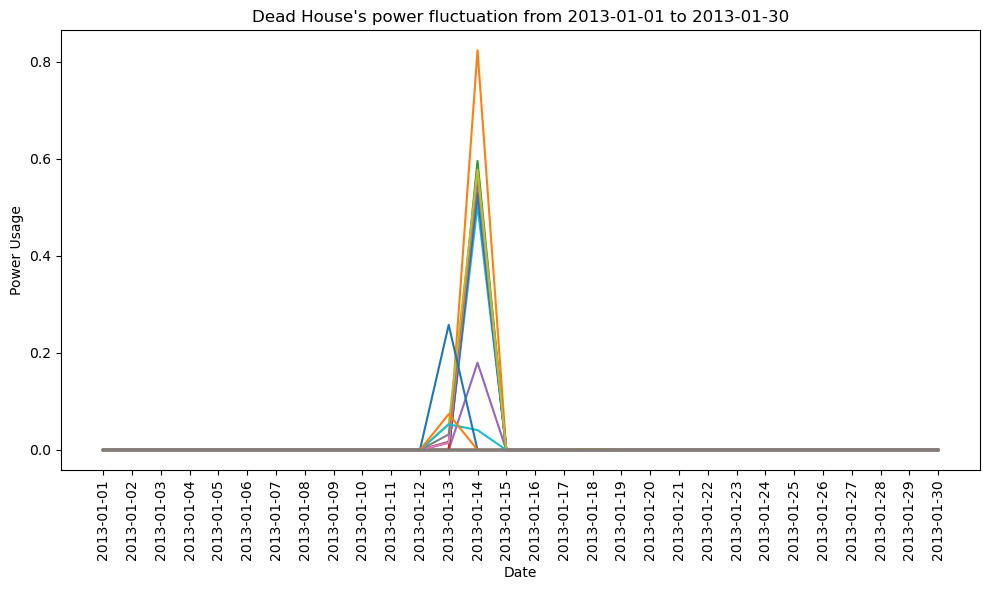

In [ ]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(subset_data)
plt.xlabel('Date')
plt.ylabel('Power Usage')
plt.title('Dead House\'s power fluctuation from {} to {}'.format(start_date, end_date))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()